# Deep Convolutional GANs

In this notebook, you'll build a GAN using convolutional layers in the generator and discriminator. This is called a Deep Convolutional GAN, or DCGAN for short. The DCGAN architecture was first explored last year and has seen impressive results in generating new images, you can read the [original paper here](https://arxiv.org/pdf/1511.06434.pdf).

You'll be training DCGAN on the [Street View House Numbers](http://ufldl.stanford.edu/housenumbers/) (SVHN) dataset. These are color images of house numbers collected from Google street view. SVHN images are in color and much more variable than MNIST. 

![SVHN Examples](assets/SVHN_examples.png)

So, we'll need a deeper and more powerful network. This is accomplished through using convolutional layers in the discriminator and generator. It's also necessary to use batch normalization to get the convolutional networks to train. The only real changes compared to what [you saw previously](https://github.com/udacity/deep-learning/tree/master/gan_mnist) are in the generator and discriminator, otherwise the rest of the implementation is the same.

In [1]:
%matplotlib inline

import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tensorflow as tf

/home/paperspace/anaconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Getting the data

Here you can download the SVHN dataset. Run the cell above and it'll download to your machine.

In [2]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

data_dir = 'data/'

if not isdir(data_dir):
    raise Exception("Data directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook)

if not isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Testing Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
            data_dir + 'test_32x32.mat',
            pbar.hook)

These SVHN files are `.mat` files typically used with Matlab. However, we can load them in with `scipy.io.loadmat` which we imported above.

In [3]:
trainset = loadmat(data_dir + 'train_32x32.mat')
testset = loadmat(data_dir + 'test_32x32.mat')

Here I'm showing a small sample of the images. Each of these is 32x32 with 3 color channels (RGB). These are the real images we'll pass to the discriminator and what the generator will eventually fake.

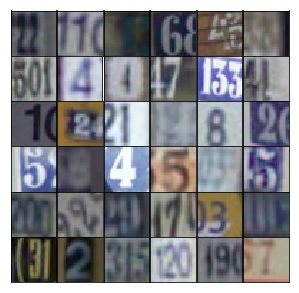

In [4]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

Here we need to do a bit of preprocessing and getting the images into a form where we can pass batches to the network. First off, we need to rescale the images to a range of -1 to 1, since the output of our generator is also in that range. We also have a set of test and validation images which could be used if we're trying to identify the numbers in the images.

In [5]:
def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [6]:
class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        split_idx = int(len(test['y'])*(1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_idx], test['X'][:,:,:,split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
     
        # why roll axis backwards? due to mnist?
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        if self.shuffle:
            idx = np.arange(len(dataset.train_x))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
            self.train_y = self.train_y[idx]
        
        n_batches = len(self.train_y)//batch_size
        for ii in range(0, len(self.train_y), batch_size):
            x = self.train_x[ii:ii+batch_size]
            y = self.train_y[ii:ii+batch_size]
            
            yield self.scaler(x), y

## Network Inputs

Here, just creating some placeholders like normal.

In [7]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

## Generator

Here you'll build the generator network. The input will be our noise vector `z` as before. Also as before, the output will be a $tanh$ output, but this time with size 32x32 which is the size of our SVHN images.

What's new here is we'll use convolutional layers to create our new images. The first layer is a fully connected layer which is reshaped into a deep and narrow layer, something like 4x4x1024 as in the original DCGAN paper. Then we use batch normalization and a leaky ReLU activation. Next is a transposed convolution where typically you'd halve the depth and double the width and height of the previous layer. Again, we use batch normalization and leaky ReLU. For each of these layers, the general scheme is convolution > batch norm > leaky ReLU.

You keep stacking layers up like this until you get the final transposed convolution layer with shape 32x32x3. Below is the archicture used in the original DCGAN paper:

![DCGAN Generator](assets/dcgan.png)

Note that the final layer here is 64x64x3, while for our SVHN dataset, we only want it to be 32x32x3. 

>**Exercise:** Build the transposed convolutional network for the generator in the function below. Be sure to use leaky ReLUs on all the layers except for the last tanh layer, as well as batch normalization on all the transposed convolutional layers except the last one.

In [8]:
def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    with tf.variable_scope('generator', reuse=reuse):
        
        # First fully connected layer
        x = tf.layers.dense(z, 4*4*512, activation=None)
        x = tf.reshape(x, shape=(-1,4,4,512))
        x = tf.layers.batch_normalization(x, training=training)
        x = tf.maximum(alpha*x, x)
        # why batch norm and relu in first layer?

        # deconv
        def deconv_layer(inp, filters, kernel_size, strides, padding):
            out = tf.layers.conv2d_transpose(inp, filters=filters,
                                      kernel_size=kernel_size,
                                      strides=strides,
                                      padding=padding)
            out = tf.layers.batch_normalization(out, axis=-1, training=training)
            out = tf.maximum(alpha*out, out)
            return out
    
        x = deconv_layer(x, 256, (3,3), (2,2), padding='same')
        # now 8x8
        x = deconv_layer(x, 128, (5,5), (2,2), padding='same')
        # now 16x16
        
        # Output layer, 32x32x3
        logits = tf.layers.conv2d_transpose(x, output_dim, (5,5), (2,2), padding='same')
        # now 32x32
        out = tf.tanh(logits)
        
        return out

## Discriminator

Here you'll build the discriminator. This is basically just a convolutional classifier like you've built before. The input to the discriminator are 32x32x3 tensors/images. You'll want a few convolutional layers, then a fully connected layer for the output. As before, we want a sigmoid output, and you'll need to return the logits as well. For the depths of the convolutional layers I suggest starting with 16, 32, 64 filters in the first layer, then double the depth as you add layers. Note that in the DCGAN paper, they did all the downsampling using only strided convolutional layers with no maxpool layers.

You'll also want to use batch normalization with `tf.layers.batch_normalization` on each layer except the first convolutional and output layers. Again, each layer should look something like convolution > batch norm > leaky ReLU.

Note: in this project, your batch normalization layers will always use batch statistics. (That is, always set `training` to `True`.) That's because we are only interested in using the discriminator to help train the generator. However, if you wanted to use the discriminator for inference later, then you would need to set the `training` parameter appropriately.

>**Exercise:** Build the convolutional network for the discriminator. The input is a 32x32x3 images, the output is a sigmoid plus the logits. Again, use Leaky ReLU activations and batch normalization on all the layers except the first.

In [9]:
def discriminator(x, reuse=False, alpha=0.2, training=True):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3

        # conv layer
        def conv_layer(inp, filters, kernel_size, strides, padding, batch_norm=True):
            out = tf.layers.conv2d(inp, filters=filters,
                                      kernel_size=kernel_size,
                                      strides=strides,
                                      padding=padding)
            if batch_norm:
                out = tf.layers.batch_normalization(out, axis=-1, training=training)
            out = tf.maximum(alpha*out, out)
            return out
            
        # no batch norm in first layer - why?
        x = conv_layer(x, 32, (5,5), (2,2), padding='same')
        # now 16x16
        x = conv_layer(x, 64, (5,5), (2,2), padding='same')
        # now 8x8
        x = conv_layer(x, 128, (5,5), (2,2), padding='same')
        # now 4x4
        x = conv_layer(x, 256, (3,3), (2,2), padding='same')
        # now 2x2
        x = tf.reshape(x, shape=(-1, 2*2*256))

        logits = tf.layers.dense(x, 1, activation=None)
        out = tf.nn.sigmoid(logits)
        
        return out, logits

## Model Loss

Calculating the loss like before, nothing new here.

In [10]:
def model_loss(input_real, input_z, output_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, output_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

## Optimizers

Not much new here, but notice how the train operations are wrapped in a `with tf.control_dependencies` block so the batch normalization layers can update their population statistics.

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

## Building the model

Here we can use the functions we defined about to build the model as a class. This will make it easier to move the network around in our code since the nodes and operations in the graph are packaged in one object.

In [12]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        self.input_real, self.input_z = model_inputs(real_size, z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              real_size[2], alpha=alpha)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

Here is a function for displaying generated images.

In [13]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off') # easy way to turn of axess?
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced') # what this does?
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

And another function we can use to train our network. Notice when we call `generator` to create the samples to display, we set `training` to `False`. That's so the batch normalization layers will use the population statistics rather than the batch statistics. Also notice that we set the `net.input_real` placeholder when we run the generator's optimizer. The generator doesn't actually use it, but we'd get an error without it because of the `tf.control_dependencies` block we created in `model_opt`. 

In [14]:
def train(net, dataset, epochs, batch_size, print_every=10, show_every=100, figsize=(5,5)):
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for x, y in dataset.batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: x, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: x})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(net.input_z, 3, reuse=True, training=False),
                                   feed_dict={net.input_z: sample_z})
                    samples.append(gen_samples)
                    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    plt.show()

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples

In [15]:
# note: use class for the neural net, call tensors as attributes to class

## Hyperparameters

GANs are very sensitive to hyperparameters. A lot of experimentation goes into finding the best hyperparameters such that the generator and discriminator don't overpower each other. Try out your own hyperparameters or read [the DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) to see what worked for them.

>**Exercise:** Find hyperparameters to train this GAN. The values found in the DCGAN paper work well, or you can experiment on your own. In general, you want the discriminator loss to be around 0.3, this means it is correctly classifying images as fake or real about 50% of the time.

In [16]:
real_size = (32,32,3)
z_size = 100
# parameters from solution
learning_rate = 0.0002
batch_size = 128
epochs = 25
alpha = 0.2
beta1 = 0.5

# Create the network
net = GAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)

Epoch 1/25... Discriminator Loss: 1.2742... Generator Loss: 0.6934
Epoch 1/25... Discriminator Loss: 0.9023... Generator Loss: 0.8918
Epoch 1/25... Discriminator Loss: 0.3834... Generator Loss: 1.7028
Epoch 1/25... Discriminator Loss: 0.5574... Generator Loss: 1.3410
Epoch 1/25... Discriminator Loss: 1.3845... Generator Loss: 0.5573
Epoch 1/25... Discriminator Loss: 1.1751... Generator Loss: 0.5514
Epoch 1/25... Discriminator Loss: 1.1415... Generator Loss: 0.9335
Epoch 1/25... Discriminator Loss: 1.0549... Generator Loss: 0.8515
Epoch 1/25... Discriminator Loss: 0.8532... Generator Loss: 1.1460
Epoch 1/25... Discriminator Loss: 0.7307... Generator Loss: 1.1110


/home/paperspace/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


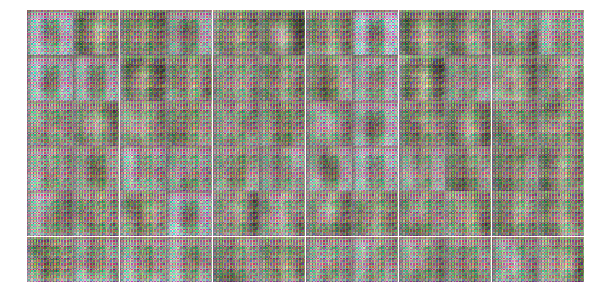

Epoch 1/25... Discriminator Loss: 0.4721... Generator Loss: 1.6469
Epoch 1/25... Discriminator Loss: 0.8060... Generator Loss: 0.8519
Epoch 1/25... Discriminator Loss: 0.4224... Generator Loss: 2.3396
Epoch 1/25... Discriminator Loss: 0.4539... Generator Loss: 1.6260
Epoch 1/25... Discriminator Loss: 1.3864... Generator Loss: 0.4280
Epoch 1/25... Discriminator Loss: 0.9124... Generator Loss: 1.2014
Epoch 1/25... Discriminator Loss: 1.4035... Generator Loss: 0.3510
Epoch 1/25... Discriminator Loss: 0.4645... Generator Loss: 1.5484
Epoch 1/25... Discriminator Loss: 1.4936... Generator Loss: 3.7737
Epoch 1/25... Discriminator Loss: 0.3643... Generator Loss: 1.9355


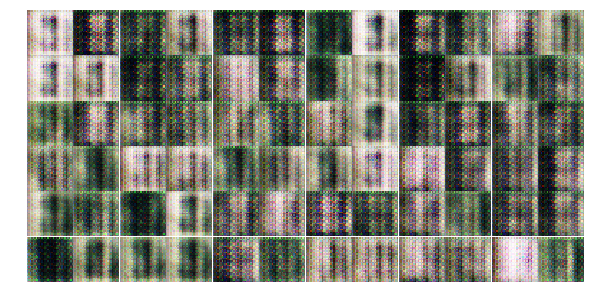

Epoch 1/25... Discriminator Loss: 0.3205... Generator Loss: 2.1654
Epoch 1/25... Discriminator Loss: 0.2975... Generator Loss: 1.9845
Epoch 1/25... Discriminator Loss: 1.1961... Generator Loss: 3.6324
Epoch 1/25... Discriminator Loss: 0.6512... Generator Loss: 0.9647
Epoch 1/25... Discriminator Loss: 0.8506... Generator Loss: 2.5106
Epoch 1/25... Discriminator Loss: 1.2853... Generator Loss: 0.4197
Epoch 1/25... Discriminator Loss: 0.3146... Generator Loss: 3.2917
Epoch 1/25... Discriminator Loss: 0.6423... Generator Loss: 1.2387
Epoch 1/25... Discriminator Loss: 0.5282... Generator Loss: 1.6358
Epoch 1/25... Discriminator Loss: 1.0404... Generator Loss: 2.6969


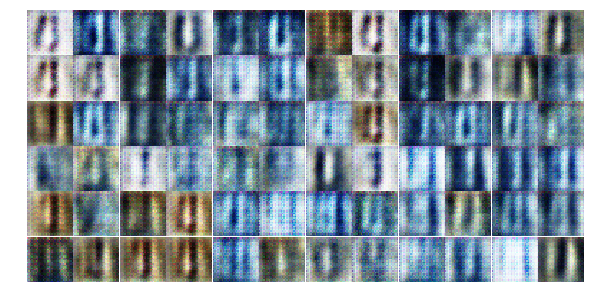

Epoch 1/25... Discriminator Loss: 0.7694... Generator Loss: 1.0540
Epoch 1/25... Discriminator Loss: 0.5953... Generator Loss: 1.0620
Epoch 1/25... Discriminator Loss: 0.2507... Generator Loss: 2.1765
Epoch 1/25... Discriminator Loss: 0.6377... Generator Loss: 1.2808
Epoch 1/25... Discriminator Loss: 0.7593... Generator Loss: 0.8571
Epoch 1/25... Discriminator Loss: 0.4812... Generator Loss: 1.6946
Epoch 1/25... Discriminator Loss: 0.5886... Generator Loss: 1.2354
Epoch 1/25... Discriminator Loss: 0.5910... Generator Loss: 1.5537
Epoch 1/25... Discriminator Loss: 1.0354... Generator Loss: 1.9776
Epoch 1/25... Discriminator Loss: 0.6292... Generator Loss: 1.2885


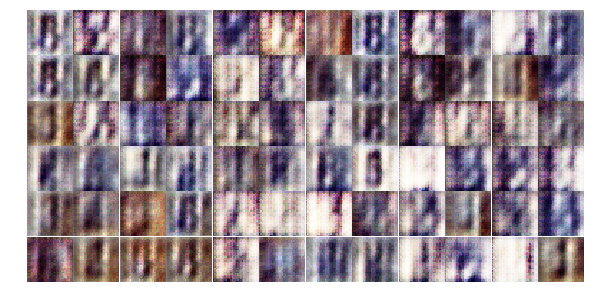

Epoch 1/25... Discriminator Loss: 0.8476... Generator Loss: 0.9231
Epoch 1/25... Discriminator Loss: 0.6533... Generator Loss: 1.9765
Epoch 1/25... Discriminator Loss: 0.5875... Generator Loss: 1.8094
Epoch 1/25... Discriminator Loss: 1.6552... Generator Loss: 0.4564
Epoch 1/25... Discriminator Loss: 0.4733... Generator Loss: 2.3083
Epoch 1/25... Discriminator Loss: 0.9804... Generator Loss: 0.7662
Epoch 1/25... Discriminator Loss: 1.0405... Generator Loss: 0.6824
Epoch 1/25... Discriminator Loss: 1.4687... Generator Loss: 1.6701
Epoch 1/25... Discriminator Loss: 0.7022... Generator Loss: 1.1471
Epoch 1/25... Discriminator Loss: 0.6427... Generator Loss: 1.2011


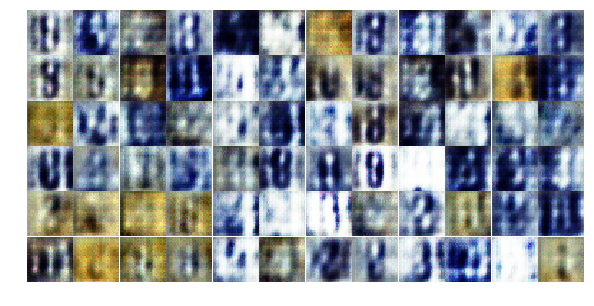

Epoch 1/25... Discriminator Loss: 0.8714... Generator Loss: 1.1958
Epoch 1/25... Discriminator Loss: 1.1876... Generator Loss: 0.7404
Epoch 1/25... Discriminator Loss: 1.0271... Generator Loss: 2.6194
Epoch 1/25... Discriminator Loss: 0.6995... Generator Loss: 0.9994
Epoch 1/25... Discriminator Loss: 0.9274... Generator Loss: 3.9169
Epoch 1/25... Discriminator Loss: 0.4385... Generator Loss: 1.7216
Epoch 1/25... Discriminator Loss: 0.4202... Generator Loss: 1.6166
Epoch 2/25... Discriminator Loss: 0.6013... Generator Loss: 2.0974
Epoch 2/25... Discriminator Loss: 0.6672... Generator Loss: 1.6427
Epoch 2/25... Discriminator Loss: 0.5783... Generator Loss: 1.4837


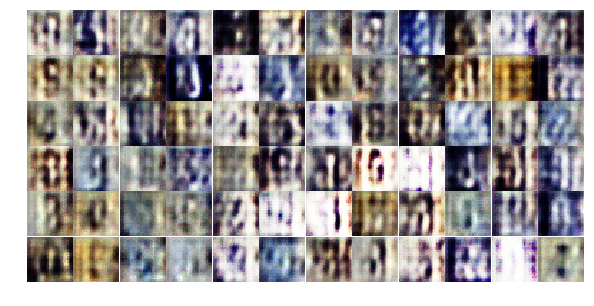

Epoch 2/25... Discriminator Loss: 0.3954... Generator Loss: 1.8121
Epoch 2/25... Discriminator Loss: 0.8575... Generator Loss: 2.7099
Epoch 2/25... Discriminator Loss: 0.8932... Generator Loss: 2.7243
Epoch 2/25... Discriminator Loss: 0.8160... Generator Loss: 1.2109
Epoch 2/25... Discriminator Loss: 0.4802... Generator Loss: 1.4201
Epoch 2/25... Discriminator Loss: 0.3934... Generator Loss: 1.6002
Epoch 2/25... Discriminator Loss: 0.1361... Generator Loss: 4.3845
Epoch 2/25... Discriminator Loss: 1.3430... Generator Loss: 1.9282
Epoch 2/25... Discriminator Loss: 0.2683... Generator Loss: 1.9573
Epoch 2/25... Discriminator Loss: 0.1849... Generator Loss: 2.7021


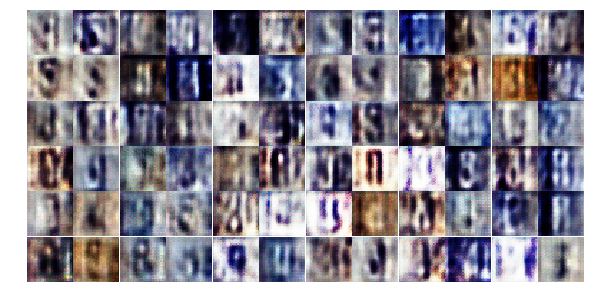

Epoch 2/25... Discriminator Loss: 0.3443... Generator Loss: 2.7168
Epoch 2/25... Discriminator Loss: 0.4788... Generator Loss: 1.1696
Epoch 2/25... Discriminator Loss: 0.5309... Generator Loss: 2.7088
Epoch 2/25... Discriminator Loss: 0.5976... Generator Loss: 3.2870
Epoch 2/25... Discriminator Loss: 0.5130... Generator Loss: 1.1416
Epoch 2/25... Discriminator Loss: 0.3946... Generator Loss: 1.4037
Epoch 2/25... Discriminator Loss: 0.1682... Generator Loss: 2.6745
Epoch 2/25... Discriminator Loss: 0.8264... Generator Loss: 2.3597
Epoch 2/25... Discriminator Loss: 0.2247... Generator Loss: 3.0167
Epoch 2/25... Discriminator Loss: 1.0831... Generator Loss: 5.9033


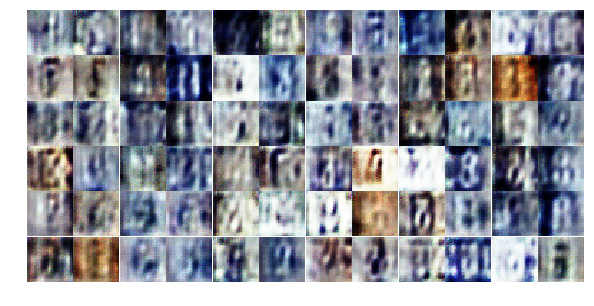

Epoch 2/25... Discriminator Loss: 1.2858... Generator Loss: 0.5274
Epoch 2/25... Discriminator Loss: 0.8284... Generator Loss: 4.1706
Epoch 2/25... Discriminator Loss: 1.2828... Generator Loss: 2.0276
Epoch 2/25... Discriminator Loss: 0.2665... Generator Loss: 4.7860
Epoch 2/25... Discriminator Loss: 0.4271... Generator Loss: 1.9029
Epoch 2/25... Discriminator Loss: 0.4439... Generator Loss: 1.5320
Epoch 2/25... Discriminator Loss: 0.9608... Generator Loss: 0.6279
Epoch 2/25... Discriminator Loss: 0.7223... Generator Loss: 0.8505
Epoch 2/25... Discriminator Loss: 1.2928... Generator Loss: 6.3304
Epoch 2/25... Discriminator Loss: 0.5569... Generator Loss: 1.2467


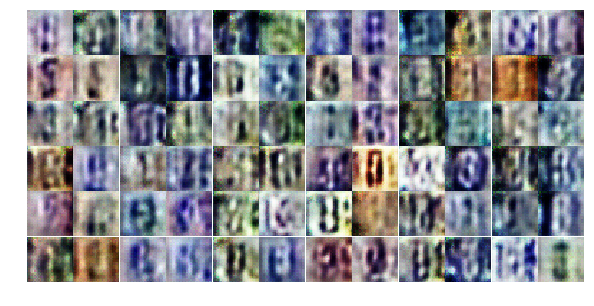

Epoch 2/25... Discriminator Loss: 0.1587... Generator Loss: 3.5858
Epoch 2/25... Discriminator Loss: 0.8115... Generator Loss: 1.1639
Epoch 2/25... Discriminator Loss: 1.1062... Generator Loss: 1.7460
Epoch 2/25... Discriminator Loss: 0.8342... Generator Loss: 1.4782
Epoch 2/25... Discriminator Loss: 0.5958... Generator Loss: 1.1730
Epoch 2/25... Discriminator Loss: 0.5034... Generator Loss: 1.3105
Epoch 2/25... Discriminator Loss: 1.2623... Generator Loss: 4.3080
Epoch 2/25... Discriminator Loss: 1.3718... Generator Loss: 6.2896
Epoch 2/25... Discriminator Loss: 1.4694... Generator Loss: 0.3289
Epoch 2/25... Discriminator Loss: 1.7831... Generator Loss: 0.2273


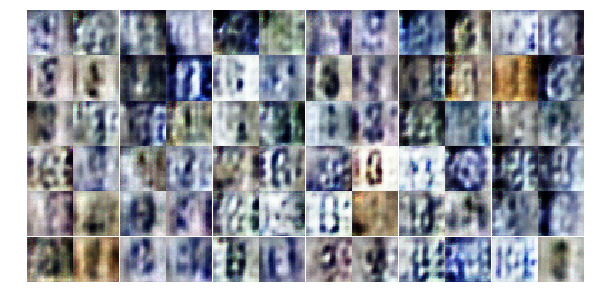

Epoch 2/25... Discriminator Loss: 0.1360... Generator Loss: 3.8828
Epoch 2/25... Discriminator Loss: 2.4262... Generator Loss: 3.5523
Epoch 2/25... Discriminator Loss: 0.2523... Generator Loss: 5.7816
Epoch 2/25... Discriminator Loss: 0.3190... Generator Loss: 2.6726
Epoch 2/25... Discriminator Loss: 1.3495... Generator Loss: 0.3864
Epoch 2/25... Discriminator Loss: 1.1096... Generator Loss: 0.5490
Epoch 2/25... Discriminator Loss: 0.5162... Generator Loss: 1.2380
Epoch 2/25... Discriminator Loss: 0.6990... Generator Loss: 1.4920
Epoch 2/25... Discriminator Loss: 0.0959... Generator Loss: 4.1781
Epoch 2/25... Discriminator Loss: 0.5449... Generator Loss: 1.2869


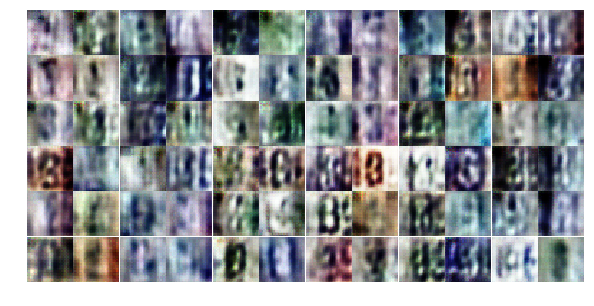

Epoch 2/25... Discriminator Loss: 0.6795... Generator Loss: 1.9348
Epoch 2/25... Discriminator Loss: 0.1179... Generator Loss: 3.0013
Epoch 2/25... Discriminator Loss: 1.0307... Generator Loss: 4.7254
Epoch 2/25... Discriminator Loss: 0.5797... Generator Loss: 1.0919
Epoch 3/25... Discriminator Loss: 1.2154... Generator Loss: 0.4428
Epoch 3/25... Discriminator Loss: 0.1390... Generator Loss: 2.8249
Epoch 3/25... Discriminator Loss: 0.8816... Generator Loss: 1.1215
Epoch 3/25... Discriminator Loss: 0.1877... Generator Loss: 3.0959
Epoch 3/25... Discriminator Loss: 1.1771... Generator Loss: 6.9132
Epoch 3/25... Discriminator Loss: 0.4634... Generator Loss: 2.5203


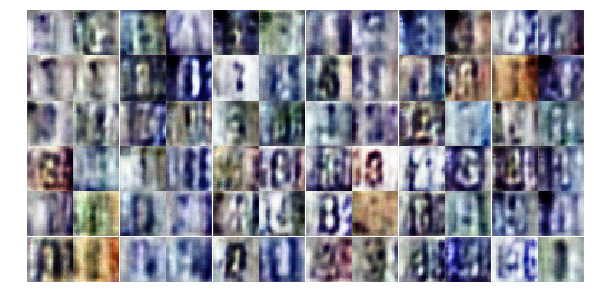

Epoch 3/25... Discriminator Loss: 0.5296... Generator Loss: 1.3079
Epoch 3/25... Discriminator Loss: 0.3430... Generator Loss: 4.3000
Epoch 3/25... Discriminator Loss: 0.1909... Generator Loss: 2.6968
Epoch 3/25... Discriminator Loss: 4.9224... Generator Loss: 7.1101
Epoch 3/25... Discriminator Loss: 0.8822... Generator Loss: 0.7221
Epoch 3/25... Discriminator Loss: 0.2461... Generator Loss: 2.2382
Epoch 3/25... Discriminator Loss: 0.4413... Generator Loss: 1.9237
Epoch 3/25... Discriminator Loss: 0.4189... Generator Loss: 1.5159
Epoch 3/25... Discriminator Loss: 0.4091... Generator Loss: 4.0866
Epoch 3/25... Discriminator Loss: 0.2252... Generator Loss: 3.5253


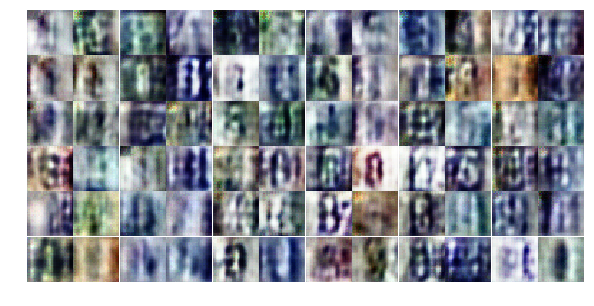

Epoch 3/25... Discriminator Loss: 0.6634... Generator Loss: 5.0158
Epoch 3/25... Discriminator Loss: 0.2582... Generator Loss: 3.7403
Epoch 3/25... Discriminator Loss: 0.5456... Generator Loss: 1.2298
Epoch 3/25... Discriminator Loss: 0.2675... Generator Loss: 2.5981
Epoch 3/25... Discriminator Loss: 0.5575... Generator Loss: 1.1368
Epoch 3/25... Discriminator Loss: 0.4006... Generator Loss: 3.5690
Epoch 3/25... Discriminator Loss: 0.8027... Generator Loss: 2.9810
Epoch 3/25... Discriminator Loss: 0.7447... Generator Loss: 0.8081
Epoch 3/25... Discriminator Loss: 0.5471... Generator Loss: 4.2712
Epoch 3/25... Discriminator Loss: 0.3251... Generator Loss: 2.7981


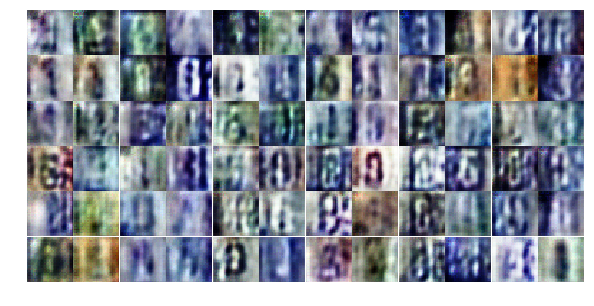

Epoch 3/25... Discriminator Loss: 0.3455... Generator Loss: 3.5672
Epoch 3/25... Discriminator Loss: 0.2864... Generator Loss: 1.7007
Epoch 3/25... Discriminator Loss: 0.5490... Generator Loss: 1.1084
Epoch 3/25... Discriminator Loss: 0.4493... Generator Loss: 1.2710
Epoch 3/25... Discriminator Loss: 1.4324... Generator Loss: 0.9000
Epoch 3/25... Discriminator Loss: 0.4717... Generator Loss: 2.1395
Epoch 3/25... Discriminator Loss: 0.9296... Generator Loss: 1.1749
Epoch 3/25... Discriminator Loss: 0.5214... Generator Loss: 1.6973
Epoch 3/25... Discriminator Loss: 0.3902... Generator Loss: 1.9043
Epoch 3/25... Discriminator Loss: 0.5520... Generator Loss: 5.8449


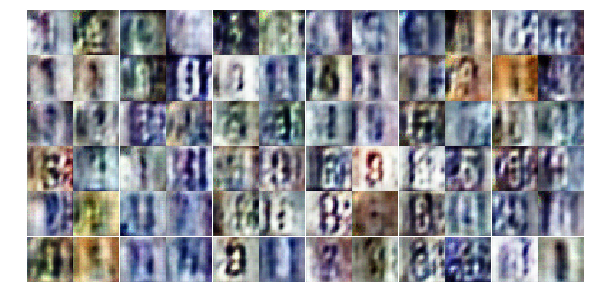

Epoch 3/25... Discriminator Loss: 0.5510... Generator Loss: 2.3324
Epoch 3/25... Discriminator Loss: 0.0744... Generator Loss: 5.0700
Epoch 3/25... Discriminator Loss: 0.0969... Generator Loss: 3.9507
Epoch 3/25... Discriminator Loss: 0.6064... Generator Loss: 0.9531
Epoch 3/25... Discriminator Loss: 0.6788... Generator Loss: 0.9378
Epoch 3/25... Discriminator Loss: 0.3147... Generator Loss: 1.8163
Epoch 3/25... Discriminator Loss: 0.3019... Generator Loss: 3.9994
Epoch 3/25... Discriminator Loss: 0.7898... Generator Loss: 1.6228
Epoch 3/25... Discriminator Loss: 0.0310... Generator Loss: 8.0268
Epoch 3/25... Discriminator Loss: 1.0754... Generator Loss: 0.5793


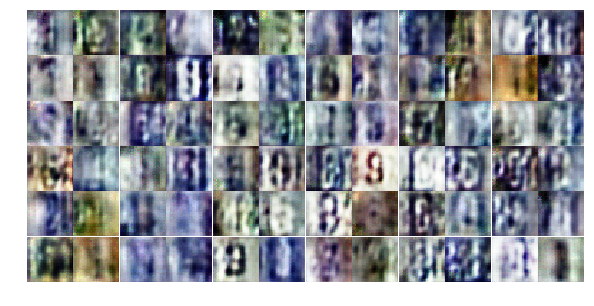

Epoch 3/25... Discriminator Loss: 0.3154... Generator Loss: 1.5676
Epoch 3/25... Discriminator Loss: 0.2575... Generator Loss: 2.7131
Epoch 3/25... Discriminator Loss: 0.4045... Generator Loss: 1.4180
Epoch 3/25... Discriminator Loss: 0.3689... Generator Loss: 1.5055
Epoch 3/25... Discriminator Loss: 0.7789... Generator Loss: 1.9347
Epoch 3/25... Discriminator Loss: 0.6845... Generator Loss: 2.4764
Epoch 3/25... Discriminator Loss: 1.1729... Generator Loss: 0.4562
Epoch 3/25... Discriminator Loss: 0.1333... Generator Loss: 2.9809
Epoch 3/25... Discriminator Loss: 0.0710... Generator Loss: 5.6306
Epoch 3/25... Discriminator Loss: 0.3856... Generator Loss: 4.8403


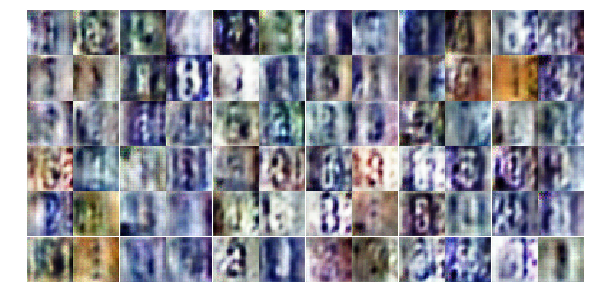

Epoch 3/25... Discriminator Loss: 2.0053... Generator Loss: 0.1862
Epoch 4/25... Discriminator Loss: 0.5702... Generator Loss: 3.2962
Epoch 4/25... Discriminator Loss: 0.4422... Generator Loss: 3.6551
Epoch 4/25... Discriminator Loss: 0.4704... Generator Loss: 1.6384
Epoch 4/25... Discriminator Loss: 0.0929... Generator Loss: 3.3629
Epoch 4/25... Discriminator Loss: 0.2672... Generator Loss: 2.1973


In [ ]:
# Load the data and train the network here
dataset = Dataset(trainset, testset)
losses, samples = train(net, dataset, epochs, batch_size, figsize=(10,5))

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [ ]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))